# Goal: Which Attributes are Strongest In Identifying Blocked Users?
### Which Blocked Users Have Two or More User IDs That Match Based on an Attribute 
---

In [1]:
# Python Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

In [2]:
query1 = """        

SELECT COUNT(*) AS num_blocked_users_total
    FROM lemonade.users
        WHERE blocked = 1;

"""

project_id = 'lemonade-production'
df1 = pd.read_gbq(query1, project_id = project_id, dialect='standard')
df1.head()

,num_blocked_users_total
0,1623


In [3]:
query2 = """        

WITH a AS
  (
  SELECT 
  l.created_at, 
  l.suspicionType, 
  l.user_1, 
  l.user_2, 
  u1.blocked AS user_1_blocked, 
  u2.blocked AS user_2_blocked
    FROM risk.account_links AS l
      JOIN lemonade.users AS u1
      ON l.user_1 = u1.id 
      JOIN lemonade.users AS u2
      ON l.user_2 = u2.id
        WHERE COALESCE(u1.blocked, u2.blocked) = 1
  ),

user_1 AS 
(
SELECT 
user_1 AS user,
suspicionType AS suspicion_type,
COUNT(*) AS num_times
  FROM a
    WHERE suspicionType NOT LIKE '%Addr'
  GROUP BY 1,2
  ORDER BY 3 DESC
),

user_2 AS
(
SELECT 
user_2 AS user,
suspicionType AS suspicion_type,
COUNT(*) AS num_times
  FROM a
    WHERE suspicionType NOT LIKE '%Addr'
  GROUP BY 1,2
  ORDER BY 3 DESC
)

SELECT DISTINCT *
FROM user_1
UNION ALL
SELECT * 
FROM user_2;

"""

project_id = 'lemonade-production'
df2 = pd.read_gbq(query2, project_id = project_id, dialect='standard')
df2.head()

,user,suspicion_type,num_times
0,173103,Device,1
1,279841,Device,1
2,465302,Person,1
3,709275,EventDevice,1
4,99385,Device,1


In [4]:
print('\n# of Blocked Users in System:', df1['num_blocked_users_total'].iloc[0])
print('# of Blocked Users that were Identified:', df2['user'].nunique(), '\n')


# of Blocked Users in System: 1623
# of Blocked Users that were Identified: 1474 



In [5]:
query3 = """        


-- Duplicate Users: BigQuery

WITH a AS
  (
  SELECT
  c.entity_id AS user_id,
  MIN(c.created_at) AS earliest_block
    FROM lemonade.comments AS c
        JOIN lemonade.users AS u
        ON c.entity_id = u.id
      WHERE type = 'block' 
      AND entity_type = 'users'
    GROUP BY 1 
  ),

b AS
  (
  SELECT 
  l.suspicionType, 
  l.user_1, 
  l.user_2,
  a.earliest_block AS earliest_block,
  MIN(l.created_at) AS earliest_duplicate
    FROM risk.account_links AS l
      JOIN lemonade.users AS u2
      ON l.user_2 = u2.id
      JOIN a
      ON a.user_id = l.user_2
        WHERE u2.blocked = 1
   GROUP BY 1,2,3,4
     -- Remove entries where block happened after match was identified
     -- HAVING earliest_block < earliest_duplicate
  ),

user_1 AS 
(
SELECT 
user_1 AS user,
suspicionType,
COUNT(*) AS num_times
  FROM b
      WHERE suspicionType NOT LIKE '%Addr'
  GROUP BY 1,2
  ORDER BY 3 DESC
)

SELECT
suspicionType AS suspicion_type,
COUNT(DISTINCT user) AS num_blocked_users 
  FROM user_1
  GROUP BY 1
  ORDER BY 2 DESC;

"""

project_id = 'lemonade-production'
df = pd.read_gbq(query3, project_id = project_id, dialect='standard')
df['pct_of_total_blocked_users'] = round(100.0 * df['num_blocked_users'] / df1['num_blocked_users_total'].iloc[0], 2)
df

,suspicion_type,num_blocked_users,pct_of_total_blocked_users
0,Person,445,27.42
1,Device,396,24.40
2,UUID,327,20.15
3,Card,195,12.01
4,EventDevice,153,9.43
5,Phone,135,8.32
6,BankAccount,14,0.86
7,Email,10,0.62


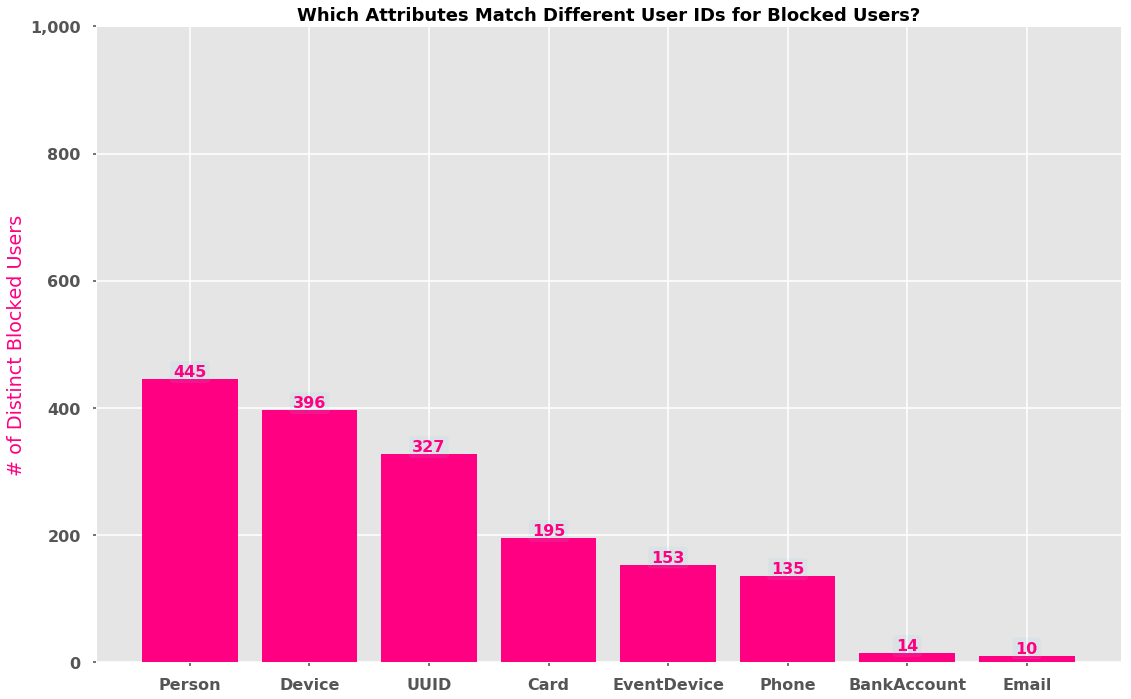

In [6]:
# profile = pandas_profiling.ProfileReport(df)
# profile

style.use('seaborn-poster')
style.use('ggplot')
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'bold'

fig, ax = plt.subplots(figsize=(16,10))

ax.bar(df['suspicion_type'], df['num_blocked_users'], color='#ff0083')
ax.set_title("Which Attributes Match Different User IDs for Blocked Users?", fontsize=18, fontweight='bold')
ax.set_ylabel('# of Distinct Blocked Users', color='#ff0083')
ax.yaxis.label.set_color('#ff0083')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,1000)

def add_value_labels(ax, spacing = 15, vert = 'top'):
    
    for rect in ax.patches:

        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = vert
        label = "{:.0f}".format(y_value)
        
        plt.annotate (
            label,
            (x_value, y_value),
            xytext = (0, space),
            textcoords = "offset points",
            ha = 'center',
            va = va,
            color='#ff0083',
            bbox=dict(boxstyle='round,pad=0.2', fc='skyblue', alpha=0.1),
            fontsize=16,
        )

add_value_labels(ax)

plt.tight_layout()
plt.savefig("Duplicate Blocked Users - Strongest Identifiers.png", bbox_inches='tight');

In [9]:
query4 = """        


-- Duplicate Users: BigQuery

WITH a AS
  (
  SELECT
  c.entity_id AS user_id,
  MIN(c.created_at) AS earliest_block
    FROM lemonade.comments AS c
        JOIN lemonade.users AS u
        ON c.entity_id = u.id
      WHERE type = 'block' 
      AND entity_type = 'users'
    GROUP BY 1 
  ),

b AS
  (
  SELECT 
  l.suspicionType, 
  l.user_1, 
  l.user_2,
  a.earliest_block AS earliest_block,
  MIN(l.created_at) AS earliest_duplicate
    FROM risk.account_links AS l
      JOIN lemonade.users AS u2
      ON l.user_2 = u2.id
      JOIN a
      ON a.user_id = l.user_2
        WHERE u2.blocked = 1
   GROUP BY 1,2,3,4
     -- Remove entries where block happened after match was identified
     HAVING earliest_block < earliest_duplicate
  ),

user_1 AS 
(
SELECT 
user_1 AS user,
suspicionType,
COUNT(*) AS num_times
  FROM b
    WHERE suspicionType NOT LIKE '%Addr'
  GROUP BY 1,2
  ORDER BY 3 DESC
)

SELECT
suspicionType AS suspicion_type,
COUNT(DISTINCT user) AS num_blocked_users 
  FROM user_1
  GROUP BY 1
  ORDER BY 2 DESC;

"""

project_id = 'lemonade-production'
df = pd.read_gbq(query4, project_id = project_id, dialect='standard')
df['pct_of_total_blocked_users'] = round(100.0 * df['num_blocked_users'] / df1['num_blocked_users_total'].iloc[0], 2)
df

,suspicion_type,num_blocked_users,pct_of_total_blocked_users
0,Person,148,9.12
1,Device,129,7.95
2,Phone,95,5.85
3,UUID,85,5.24
4,EventDevice,51,3.14
5,Card,22,1.36
6,BankAccount,7,0.43
7,Email,2,0.12


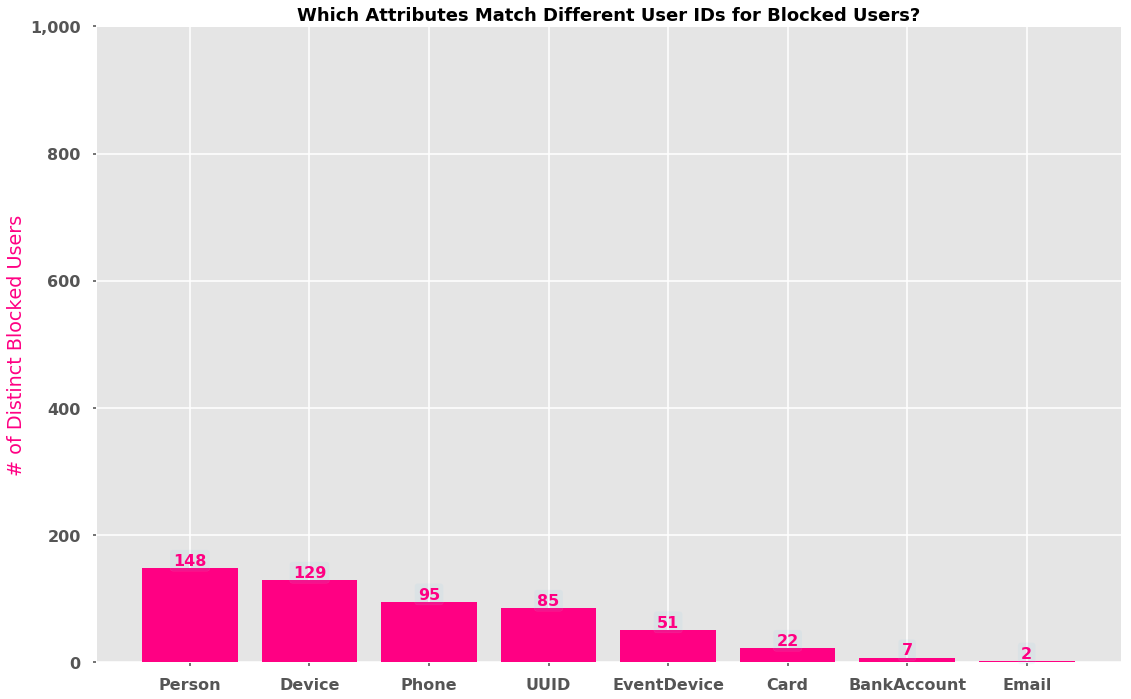

In [10]:
# profile = pandas_profiling.ProfileReport(df)
# profile

style.use('seaborn-poster')
style.use('ggplot')
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'bold'

fig, ax = plt.subplots(figsize=(16,10))

ax.bar(df['suspicion_type'], df['num_blocked_users'], color='#ff0083')
ax.set_title("Which Attributes Match Different User IDs for Blocked Users?", fontsize=18, fontweight='bold')
ax.set_ylabel('# of Distinct Blocked Users', color='#ff0083')
ax.yaxis.label.set_color('#ff0083')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,1000)

def add_value_labels(ax, spacing = 15, vert = 'top'):
    
    for rect in ax.patches:

        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = vert
        label = "{:.0f}".format(y_value)
        
        plt.annotate (
            label,
            (x_value, y_value),
            xytext = (0, space),
            textcoords = "offset points",
            ha = 'center',
            va = va,
            color='#ff0083',
            bbox=dict(boxstyle='round,pad=0.2', fc='skyblue', alpha=0.1),
            fontsize=16,
        )

add_value_labels(ax)

plt.tight_layout()
plt.savefig("Duplicate Blocked Users - Strongest Identifiers (Not Forward Looking).png", bbox_inches='tight');

---